In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import random
import re

# Comparison on multiple datasets

In [28]:
import openml
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
import os
import shap
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
import pickle
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.neighbors import NearestNeighbors
import graphviz

from sklearn import tree
from sklearn.tree import  export_graphviz
from graphviz import Source
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from IPython.display import display
from IPython.display import SVG

from anchor import utils
from anchor import anchor_tabular
from pyuid3.data import Data
from pyuid3.entropy_evaluator import *
import matplotlib.pylab as plt
from matplotlib import colors,cm
import matplotlib.patches as patches
from sklearn.preprocessing import normalize
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from pyuid3.data import Data
from pyuid3.uid3 import UId3

In [29]:
import sys
sys.path.append('./EXPLAN')
import explan
from explan import DataGeneration,DataSelection,DataBalancing
from utils import *
from LORE import lore
from LORE.neighbor_generator import *
from neighbor_generator import *
from gpdatagenerator import calculate_feature_values

In [30]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [31]:
def anchor_fidelity_accuracy(X_train, X_test, clf, instance_to_explain ):
    explainer = anchor_tabular.AnchorTabularExplainer(
        ['0','1'],
        feature_names = X_train.columns,
        train_data = X_train.values,
        categorical_names={})
    
    exp = explainer.explain_instance(instance_to_explain, clf.predict, threshold=0.95)
    return explainer,exp

In [32]:
def decision_boundary(clf1,clf2,explain_instance, X,y,f1='x1',f2='x2'):
    explain_instance = pd.DataFrame([explain_instance], columns=X.columns)
    h = .02  # step size in the mesh
    # create a mesh to plot in
    x_min, x_max = X.loc[:, f1].min() - 0.5, X.loc[:, f1].max() + 0.5
    y_min, y_max = X.loc[:, f2].min() - 0.5, X.loc[:, f2].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))


    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf1.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = np.array(clf2.predict(pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=[f1,f2])))


    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig,ax= plt.subplots(1,2, figsize=(12,3))
    ax[0].contour(xx, yy, Z, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[0])

    ZZ = ZZ.reshape(xx.shape)
    ax[1].contour(xx, yy, ZZ, cmap=plt.cm.Paired)
    X.plot(kind='scatter',x=f1, y=f2,style='.', c=y, colormap='viridis',ax=ax[1])
    
    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    
    ax[0].set(title='DecTree decision boundary')
    ax[1].set(title='LUX decision boundary')
    plt.show()

In [33]:

def plot_neighbourhood(clf,X_test, y_test, X_train_sample,point, f1='x1', f2='x2', train_test_label = 'TEST'):
    explain_instance = pd.DataFrame([point], columns=X_test.columns)
    X_test_appended = pd.concat((X_test,explain_instance),axis=0,ignore_index=True)
    #y_test_appended = np.concatenate([y_test,[1]])
    y_test_appended = clf.predict(X_test_appended)
    
    fig, ax = plt.subplots(1, 2, figsize=(12,3))

    y_test_proba = clf.predict_proba(X_train_sample)
    confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba[:,0], 'CLF_1':y_test_proba[:,1]})))


    y_test_proba_o = clf.predict_proba(X_test_appended)
    confidence_svc_o =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'CLF_0':y_test_proba_o[:,0], 
                                                                                 'CLF_1':y_test_proba_o[:,1]})))

    y_tr_sam_bin = (y_test_proba[:,1]>=0.5).astype('int')
    y_tr_sam_bin_o = (y_test_proba_o[:,1]>=0.5).astype('int')

    X_test_1_o = X_test_appended.iloc[y_tr_sam_bin_o==1]
    X_test_2_o = X_test_appended.iloc[y_tr_sam_bin_o==0]
    X_test_1_o.columns=X_test.columns

    X_test_1 = X_train_sample.iloc[y_tr_sam_bin==1]
    X_test_2 = X_train_sample.iloc[y_tr_sam_bin==0]
    X_test_1.columns=X_test.columns

    cmapp = cm.viridis


    c=0
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_1_o[f1], X_test_1_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==1,1].values, cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[0].scatter(X_test_2_o[f1], X_test_2_o[f2], c=confidence_svc_o.iloc[y_tr_sam_bin_o==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[0].set(title=f'Classifier uncertainty in predicions for {train_test_label}')

    #rect = patches.Rectangle((0.5,-0.5),1,1,angle=0,ec='r', fc="None", ls='--', linewidth=2)
    
    rect = patches.Circle(tuple(explain_instance[[f1,f2]].values.ravel()),(max(X_test[f1])-min(X_test[f1]))/4,ec='r', fc="None", ls='--', linewidth=2)

    ax[0].add_patch(rect)


    c=0

    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_1[f1], X_test_1[f2], c=(confidence_svc.iloc[y_tr_sam_bin==1,1].values), cmap=cmap)#, ec=None, s=10**2)


    c=int(255*.5)
    cmap = colors.LinearSegmentedColormap.from_list(
            'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
    ax[1].scatter(X_test_2[f1], X_test_2[f2], c=confidence_svc.iloc[y_tr_sam_bin==0,0].values, cmap=cmap)#, ec=None, s=10**2)
    ax[1].set(title='Classifier uncertainty in predictions for neighbourhood $N$')

    ax[0].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    ax[1].plot(explain_instance[f1], explain_instance[f2], 'or', markersize=8)
    plt.show()

In [34]:
shap.initjs()

In [35]:
def get_plot_features(lux,explain_instance,all_features = None):
    justification=lux.justify(explain_instance)[0]
    print(justification)
    features_plot = justification.split()
    f1=features_plot[1]
    f2= justification.split('AND')[-1].split()[0] if 'AND' in justification  else f1
    other_f = [f.get_name() for f in lux.uid3.tree.get_attributes() if f != "class" and f !=f1]
    if len(set([f1,f2]))<2 and len(other_f)>0:
        f2 = other_f[0]
    if len(set([f1,f2]))<2 and all_features is not None:
        f2 =[f for f in all_features if f != "class" and f !=f1][0]
    return tuple(np.sort([f1,f2]))

In [36]:
def prepare_ds(df, name = 'dataset', class_name='class', discrete=[], label_encoder={}):
    features = [f for f in df.columns if f not in [class_name]]
    
    dataset = {}
    dataset['name'] = name
    dataset['df'] = df
    dataset['columns'] = list(df.columns)
    dataset['class_name'] = class_name
    dataset['possible_outcomes'] = list(np.unique(df[class_name]))
    
    types = {}
    types['integer'] = [c for c,t in zip(df.columns, df.dtypes) if 'int' in str(t)]
    types['double'] = [c for c,t in zip(df.columns, df.dtypes) if 'float' in str(t)]
    types['string'] = [c for c,t in zip(df.columns, df.dtypes) if 'str' in str(t) or 'object' in str(t)]
    dataset['type_features'] = types
    
    
    typemap={}
    typemap['object'] = 'string'
    typemap['float64'] = 'double'
    typemap['int64'] = 'integer'
    dataset['features_type'] = dict(zip(df.columns, map(lambda x: typemap[str(x)],df.dtypes)))
    
    dataset['discrete'] = list(df[features].columns[discrete])
    dataset['continuous'] = [f for f in features if f not in dataset['discrete']]
    dataset['idx_features'] = dict(enumerate(df[features].columns))
    dataset['label_encoder'] = label_encoder
    dataset['discrete_indices'] = [list(df.columns).index(f) for f in dataset['discrete']] 
    dataset['discrete_names'] = dict(zip(dataset['discrete_indices'],[np.unique(df[features[i]]) for i in dataset['discrete_indices']]))
    dataset['feature_names'] = features
    dataset['X'] =  df[dataset['feature_names']].values
    dataset['y'] = df[dataset['class_name']].values
    
    return dataset


In [37]:
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
class CategoricalWrapper(BaseEstimator):
    def __init__(self, model, ohe_encoder = None, categorical_indicator=None, features = None, categories='auto'):
        if ohe_encoder is None:
            self.ohe_encoder = OneHotEncoder(categories=categories)
        else:
            self.ohe_encoder = ohe_encoder
            
        self.features = features
        self.categories=categories
        self.categorical_indicator=categorical_indicator
        self.ct = ColumnTransformer(  
            [("categorical", self.ohe_encoder, [f for f,c in zip(features,categorical_indicator) if c ] )],
        remainder='passthrough')
        
        self.model = model
    
    def fit(self, X,y):
        X_tr = self.ct.fit_transform(X)
        self.model.fit(X_tr,y)
        return self
    def predict(self,X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict(self.ct.transform(X))
    
    def predict_proba(self, X):
        if type(X) is np.ndarray and self.features is not None:
            X = pd.DataFrame(X,columns=features)
        return self.model.predict_proba(self.ct.transform(X))

In [38]:
def average_jackart(rule_1, rule_2, dataset, features, categorical_indicator, lux_format=False):
    total_jackart = 0
    for i,v in rule_1.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        v1 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(v))[i]
        if i in rule_2.keys():
            v2 = dataset.query(f'{i}{op}'+f'and {i}{op}'.join(rule_2[i]))[i]
            if len((set(v1)|set(v2))) == 0:
                jackard = 0
            else:
                jackard = len(set(v1) & set(v2))/len((set(v1)|set(v2)))
        else:
            jackard=0
        total_jackart += jackard
    div = len(set(rule_1.keys())|set(rule_2.keys()))
    if div == 0:
        return 0
    else:
        return total_jackart/div
    

In [39]:
def coverage_precision(rule, dataset, features, categorical_indicator, prediction, 
                       class_label='class', average='micro', lux_format=False):
    query = []
    if rule == {}:
        accuracy =  accuracy_score(dataset['class'],np.ones(len(dataset))*float(prediction))
        precision =  precision_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        recall =  recall_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        f1 =  f1_score(dataset['class'],np.ones(len(dataset))*float(prediction), average=average)
        return 1,accuracy, precision, recall, f1
    for i,v in rule.items():
        op = '' if  dict(zip(features, categorical_indicator))[i] == False or lux_format == False else '=='
        query.append(f'{i}{op}'+f' and {i}{op}'.join(v))
    print(' and '.join(query))
    covered = dataset.query(' and '.join(query))
    predictions = np.ones(covered['class'].shape[0])*float(prediction)
    
    accuracy =  accuracy_score(covered['class'],predictions)
    precision =  precision_score(covered['class'],predictions, average=average)
    recall =  recall_score(covered['class'],predictions, average=average)
    f1 =  f1_score(covered['class'],predictions, average=average)
        
    return len(covered)/len(dataset), accuracy, precision, recall, f1

In [40]:
# def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
#     #TODO: calculate stats separtelly fro each class
#     results_mean =[] 
#     results_std =[] 
#     for true_class in rules_and_instances['true_class'].unique():
#         rules = rules_and_instances[rules_and_instances['true_class']==true_class]
#         instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
#         jackart = np.zeros((rules.shape[0],rules.shape[0]))
#         for i in range(rules.shape[0]):
#             for ii in range(rules.shape[0]):
#                 jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
#         stab = jackart/(instance_similarity+1)
#         results_mean.append(np.mean(stab))
#         results_std.append(np.std(stab))
#     return (np.mean(results_mean), np.mean(results_std)) #large stability, low variance is desired

def stability_stats(rules_and_instances, for_explainer,dataset, features, categorical_indicator,lux_format=False):
    #TODO: calculate stats separtelly fro each class
    results_mean =[] 
    results_std =[] 
    feature_jackart = np.zeros((rules_and_instances.shape[0],rules_and_instances.shape[0]))
    for true_class in rules_and_instances['true_class'].unique():
        rules = rules_and_instances[rules_and_instances['true_class']==true_class]
        instance_similarity = sklearn.metrics.pairwise_distances(np.concatenate(rules['explain_instance'].values))
        jackart = np.zeros((rules.shape[0],rules.shape[0]))
        for i in range(rules.shape[0]):
            for ii in range(rules.shape[0]):
                jackart[i,ii] = average_jackart(rules.iloc[i,:][for_explainer], rules.iloc[ii,:][for_explainer], dataset, features, categorical_indicator,lux_format=lux_format)
        stab = jackart/(instance_similarity+1)
        results_mean.append(np.mean(stab))
        results_std.append(np.std(stab))
    for i in range(rules_and_instances.shape[0]):
        for ii in range(rules_and_instances.shape[0]):
            rule_1 = rules_and_instances.iloc[i,:][for_explainer]
            rule_2 = rules_and_instances.iloc[ii,:][for_explainer]
            if len(set(rule_1.keys())|set(rule_2.keys())) == 0:
                feature_jackart[i,ii] = 0
            else:
                feature_jackart[i,ii] = len(set(rule_1.keys())&set(rule_2.keys()))/len(set(rule_1.keys())|set(rule_2.keys()))

    return (np.mean(results_mean), np.mean(results_std),np.mean(feature_jackart),np.std(feature_jackart)) #large stability, low variance is desired



In [41]:
def split_rule_conditions(rule):
    r={}
    for f,inequality in rule.items():
        partial = inequality[0].split(f)
        if len(partial)>1:
            ltparts=partial[0].split('<')
            if len(ltparts) >1:
                first = '>'+ltparts[1].strip()+ltparts[0]
            else:
                gtparts=partial[0].split('>')
                first = '<'+gtparts[1].strip()+gtparts[0]            
            second = partial[1]
            r[f] = [first,second]
        else:
            r[f] = inequality
    return r

## Main comparison loop

## Benchmark, model agnostic

In [42]:
def lore_fit(clf,train, explain_instance,categorical_indicator):
    myds = prepare_ds(train,class_name='class',discrete=categorical_indicator)
    instance2explain = explain_instance.ravel()
    X_explain = np.concatenate(([instance2explain], myds['X']))
    
    Zdf,Z = generate_lore_dataset(0, X2E=X_explain, dataset=myds, blackbox=clf,ng_function=genetic_neighborhood, 
                                  discrete_use_probabilities=True, continuous_function_estimation=False)
    
    datalore = Data.parse_dataframe(Zdf)
    uid3 = UId3(max_depth=4,node_size_limit=2)
    uid3.fit(datalore,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=1)
    return uid3

In [43]:
def explan_fit(clf,train, explain_instance,features, categorical_indicator):
    myds = prepare_ds(train,class_name='class',discrete=categorical_indicator)
    #myds = prepare_ds(dfneigh_tr,discrete=categorical_indicator)
    X, y = myds['X'], myds['y']
    instance2explain = explain_instance.ravel()
    
    # EXPLAN hyper-parameters
    N_samples = 3000#n_neighbors
    tau = 250#int(n_neighbors)/len(np.unique(df[target])
    
    
    dense_samples = DataGeneration(instance2explain, clf, myds, 3000)
    # Representative data selection step
    representative_samples = DataSelection(instance2explain, clf, dense_samples, 250)
    # Data balancing step
    neighborhood_data = DataBalancing(clf, representative_samples, myds)
    
    Ndf = pd.DataFrame(neighborhood_data, columns=features)
    Ndf['class'] = clf.predict(Ndf[features])
    
    data = Data.parse_dataframe(Ndf)
    uid3 = UId3(max_depth=4,node_size_limit=2)
    uid3.fit(data,depth=0,entropyEvaluator = UncertainEntropyEvaluator(),prune=True,n_jobs=1)
    return uid3

In [44]:
def predict_lux(model,X,y=None):
        if isinstance(X, pd.DataFrame):
            pass
        elif isinstance(X,np.ndarray):
            X = pd.DataFrame(X,columns=model.attributes_names)
        else:
            raise ValueError("Only 2D arrrays are allowed as an input")
            
        if y is None:
            y = pd.Series(np.arange(X.shape[0]),name='target_unused',index=X.index) # This is not used, but Data resered last 
                
        X=pd.concat((X,y),axis=1)
        XData = Data.parse_dataframe(X,'lux')
        return [int(f.get_name()) for f in model.predict(XData.get_instances())]

In [45]:
def generate_lore_dataset(idx_record2explain, X2E, dataset, blackbox,
            ng_function=genetic_neighborhood, #generate_random_data, #genetic_neighborhood, random_neighborhood
            discrete_use_probabilities=False,
            continuous_function_estimation=False):
    random.seed(0)
    class_name = dataset['class_name']
    columns = dataset['columns']
    discrete = dataset['discrete']
    continuous = dataset['continuous']
    features_type = dataset['features_type']
    label_encoder = dataset['label_encoder']
    possible_outcomes = dataset['possible_outcomes']

    # Dataset Preprocessing
    dataset['feature_values'] = calculate_feature_values(X2E, columns, class_name, discrete, continuous, 1000,
                                                         discrete_use_probabilities, continuous_function_estimation)

    dfZ, x = dataframe2explain(X2E, dataset, idx_record2explain, blackbox)

    # Generate Neighborhood
    dfZ, Z = ng_function(dfZ, x, blackbox, dataset)
    
    return dfZ,Z
    

In [46]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

def show_shap_values(instance_to_explain, X_test, wclf, feature_columns, num_samples=1000, sorted=True):
    """
    Function to show SHAP values for a given instance using a classifier.

    Parameters:
    - instance_to_explain: The instance to explain (single row).
    - X_test: The test dataset (DataFrame) containing the features.
    - wclf: The trained classifier (e.g., a wrapped classifier for SHAP).
    - feature_columns: List of feature names.
    - num_samples: Number of samples to draw from X_test for SHAP calculation (default is 1000).
    - sorted: If True, sort the features by SHAP value in ascending order before plotting.
    """
    # Combine the instance to explain with a sample of the test set
    X_shap = pd.concat((pd.DataFrame(instance_to_explain, columns=feature_columns), 
                        X_test[feature_columns].sample(num_samples)))

    try:
        explainer = shap.Explainer(wclf, X_shap,seed=42)
        if hasattr(explainer, "shap_values"):
            shap_values = explainer.shap_values(X_shap, check_additivity=False)
        else:
            shap_values = explainer(X_shap).values
            shap_values = [sv for sv in np.moveaxis(shap_values, 2, 0)]
        if hasattr(explainer, "expected_value"):
            expected_values = explainer.expected_value
        else:
            expected_values = [np.mean(v) for v in shap_values]
    except TypeError:
        explainer = shap.Explainer(wclf.predict_proba, X_shap,seed=42)
        shap_values = explainer(X_shap).values
        shap_values = [sv for sv in np.moveaxis(shap_values, 2, 0)]
        expected_values = [np.mean(v) for v in shap_values]

    # Handle single list case
    if type(shap_values) is not list:
        shap_values = [-shap_values, shap_values]
        expected_values = [np.mean(v) for v in shap_values]

    # Calculate mean absolute SHAP values
    mean_shap_values = np.abs(shap_values).mean(0)[0]
    
    # Sort the SHAP values and feature names if sorted=True
    if sorted:
        sorted_indices = np.argsort(mean_shap_values)
        mean_shap_values = mean_shap_values[sorted_indices]
        feature_columns = np.array(feature_columns)[sorted_indices]

   

    feature_importance = pd.DataFrame(list(zip(feature_columns,mean_shap_values)),columns=['col_name','feature_importance_vals'])


    # Plot SHAP values
    plt.figure(figsize=(12, 9))
    plt.barh(feature_columns, mean_shap_values)
    plt.xlabel("Mean Absolute SHAP Value")
    plt.title("Feature Importance (SHAP Values)")
    plt.show()
    return feature_importance


In [52]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# load the data into Pandas DataFrame
df = pd.read_csv('./data/tcm5_dataset_1.csv').dropna()
# make lists with columns related to features and anomalies
anomaly_columns = [c for c in df.columns if 'Anomaly' in c]
feature_columns = [c for c in df.columns if c not in anomaly_columns]
# divide the data into X (features) and Y (labels)
X = df.loc[:, feature_columns]
Y = df.loc[:, anomaly_columns]
# create array which tells us if any type of anomaly is present in the observation
y = (Y.sum(axis=1) != 0).values

# divide dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.2, shuffle=False)

# define, train and evaluate ML model
iforest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iforest.fit(X_train)
y_test_pred = iforest.predict(X_test) == -1
f1 = f1_score(y_test, y_test_pred)
f1

0.5021834061135371

In [53]:
class NoProbaWrapper():
    def __init__(self,clf,n_classes):
        self.clf = clf
        self.n_classes= n_classes
    def predict_proba(self,X):
        hot = (self.clf.predict(X)==-1).astype(int)
        y_train_sample = np.zeros((len(hot),self.n_classes))
        for i in range(0,len(y_train_sample)):
            y_train_sample[i,hot[i]] = 1
        return y_train_sample

    def predict(self,X):
        return (self.clf.predict(X)==-1).astype(int)

wclf = NoProbaWrapper(iforest,2)
wclf.predict_proba(X)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [54]:
#correct anomaly
instance_to_explain_cr = X_test[(wclf.predict(X_test)==1) & (y_test==1)].iloc[0].values.reshape(1,-1)

#incorrect_anomaly
instance_to_explain_icr = X_test[(wclf.predict(X_test)==1) & (y_test==0)].iloc[0].values.reshape(1,-1)




luxc = LUX(predict_proba = wclf.predict_proba, classifier=wclf,neighborhood_size=0.01,max_depth=4,  min_samples=2,
                      oversampling_strategy='importance',
                      node_size_limit = 2, grow_confidence_threshold = 0,min_generate_samples=0.01)
SAMPLES=10

Permutation explainer: 102it [01:36,  1.02s/it]                         


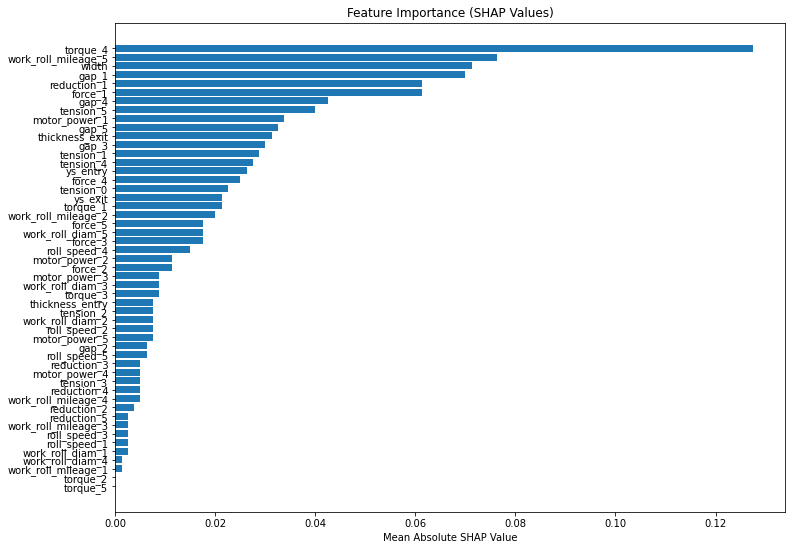

In [55]:
#show shap values for instance_to_explain_cr
shapfeatures = show_shap_values(instance_to_explain=instance_to_explain_cr, X_test=X_test, wclf=wclf, feature_columns=feature_columns, num_samples=100)

In [84]:
target='class'
test = X_test[feature_columns].copy()
test[target] = y_test
fraction=0.3
categorical_indicator=[False]*len(feature_columns)
data = Data.parse_dataframe(test[feature_columns+[target]],categorical=[False]*len(feature_columns)+[True])

In [85]:
average='binary'
pos_label=1

In [88]:
luxc = LUX(predict_proba = wclf.predict_proba, classifier=wclf,neighborhood_size=0.01,max_depth=4,  min_samples=2,
                      oversampling_strategy='importance',
                      node_size_limit = 2, grow_confidence_threshold = 0,min_generate_samples=0.01)
lux_corrects = []
for i in range(1):
    luxc.fit(X_train,wclf.predict(X_train), instance_to_explain_cr, X_importances = None, exclude_neighbourhood=False, use_parity=True,
            parity_strategy='global',inverse_sampling=True, class_names=None, discount_importance = False,
            uncertain_entropy_evaluator = UncertainEntropyEvaluator(),beta=1,representative='centroid',
            density_sampling=False, radius_sampling = False,oversampling=True,categorical=None,prune=True, oblique=True,  n_jobs=None)
    correct_justification = luxc.justify(instance_to_explain_cr)
    #cf = luxc.counterfactual(np.array(instance_to_explain_cr), X_train.sample(1000), counterfactual_representative='nearest', topn=1)[0]
    lux_corrects.append(correct_justification)
    print(correct_justification)

    fraction=0.3
    categorical_indicator=[False]*len(feature_columns)
    data = Data.parse_dataframe(test[feature_columns+[target]],categorical=[False]*len(feature_columns)+[True])
    n_neighbors=int(len(test)*fraction) # change to 0.5? or radius?
    nn = NearestNeighbors(n_neighbors=max(1,int(n_neighbors)),n_jobs=-1)
    nn.fit(test[feature_columns])
    dst,ids_c = nn.kneighbors(np.array(instance_to_explain_cr).reshape(1,-1))
    print(f'Neighbourhood size: {len(ids_c.ravel())}')
    print(f'Average distace of neighbourhood: {np.mean(dst)}.')
    dfneigh= test.iloc[ids_c.ravel()]

    predictions = [int(eval(x.get_name())) for x in luxc.uid3.predict(data.instances)]
    ac_score_shap = accuracy_score(wclf.predict(X_test[feature_columns]),predictions)
    prec_score_shap = precision_score(wclf.predict(X_test[feature_columns]),predictions, average=average,pos_label=pos_label)
    rec_score_shap = recall_score(wclf.predict(X_test[feature_columns]),predictions, average=average,pos_label=pos_label)
    f1_score_shap = f1_score(wclf.predict(X_test[feature_columns]),predictions, average=average,pos_label=pos_label)
    hit_lux_shap = (wclf.predict(instance_to_explain_cr)==luxc.predict(instance_to_explain_cr)[0])
    print(f'Fidelity  with shap: {f1_score_shap}')
    ac_score_shap_acc = accuracy_score(y_test,predictions)
    
    justification_dict = luxc.justify(instance_to_explain_cr, to_dict=True)[0][0]
    rule_lux_shap = justification_dict['rule']
    shap_lux_elen = len(justification_dict['rule'].keys())
    
    
    cov_shap, acc_shap, prec_shap, rec_shap, f1_shap = coverage_precision(rule_lux_shap, test, feature_columns, categorical_indicator, justification_dict['prediction'], class_label='class')
    cov_shap_nn, acc_shap_nn, prec_shap_nn, rec_shap_nn, f1_shap_nn = coverage_precision(rule_lux_shap, dfneigh, feature_columns, categorical_indicator, justification_dict['prediction'], class_label='class')
    
    print(f'SHAP coverage: nn: {cov_shap_nn} and local: {cov_shap}')
    print(f'Full rule: {luxc.justify(instance_to_explain_cr, to_dict=True, reduce=False)[0][0]}')
    
    justification = luxc.justify(instance_to_explain_cr)[0]
    lux_conf_shap = justification.split("#")[1]
    ats_shap= list(justification_dict['rule'].keys())
    importance_gain_shap = shapfeatures[shapfeatures['col_name'].isin(ats_shap)]['feature_importance_vals'].sum()/len(ats_shap)

Permutation explainer: 34it [00:10,  5.16s/it]                


Done 0.6666666666666666 upsampling
Done 0.030303030303030304 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')


Permutation explainer: 59it [00:25,  1.40it/s]                        


['IF torque_4 >=71023.0 THEN class = 1 # 1.0\n']
Neighbourhood size: 1200
Average distace of neighbourhood: 1367055.3809865057.
Fidelity  with shap: 0.2677925211097708
torque_4>=71023.0
torque_4>=71023.0
SHAP coverage: nn: 0.021666666666666667 and local: 0.1496751624187906
Full rule: {'rule': {'torque_4': ['>= 71023.0']}, 'prediction': '1', 'confidence': 1.0}


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []

beta_values = np.linspace(0.1, 1.0, 10)
neigh_sizes = np.linspace(0.01, 1.0, 10)

for beta in tqdm(beta_values, desc="Beta loop"):
    for neigh_size in tqdm(neigh_sizes, leave=False, desc="Neighborhood size loop"):
        luxc = LUX(
            predict_proba=wclf.predict_proba,
            classifier=wclf,
            neighborhood_size=neigh_size,
            max_depth=4,
            min_samples=2,
            oversampling_strategy='importance',
            node_size_limit=2,
            grow_confidence_threshold=0,
            min_generate_samples=0.01
        )
        
        luxc.fit(
            X_train,
            wclf.predict(X_train),
            instance_to_explain_cr,
            X_importances=None,
            exclude_neighbourhood=False,
            use_parity=True,
            parity_strategy='global',
            inverse_sampling=True,
            class_names=None,
            discount_importance=False,
            uncertain_entropy_evaluator=UncertainEntropyEvaluator(),
            beta=beta,
            representative='centroid',
            density_sampling=False,
            radius_sampling=False,
            oversampling=True,
            categorical=None,
            prune=True,
            oblique=True,
            n_jobs=None
        )

        justification_dict = luxc.justify(instance_to_explain_cr, to_dict=True)[0][0]
        rule_lux_shap = justification_dict['rule']
        shap_lux_elen = len(rule_lux_shap.keys())

        # Compute coverage/precision metrics
        categorical_indicator = [False] * len(feature_columns)
        cov_shap, _, _, _, f1_shap = coverage_precision(
            rule_lux_shap, test, feature_columns, categorical_indicator,
            justification_dict['prediction'], class_label='class'
        )

        # Neighbourhood
        n_neighbors = max(1, int(len(test) * neigh_size))
        nn = NearestNeighbors(n_neighbors=n_neighbors, n_jobs=-1)
        nn.fit(test[feature_columns])
        dst, ids_c = nn.kneighbors(np.array(instance_to_explain_cr).reshape(1, -1))
        dfneigh = test.iloc[ids_c.ravel()]
        cov_shap_nn, _, _, _, f1_shap_nn = coverage_precision(
            rule_lux_shap, dfneigh, feature_columns, categorical_indicator,
            justification_dict['prediction'], class_label='class'
        )

        # SHAP fidelity
        predictions = [int(eval(x.get_name())) for x in luxc.uid3.predict(data.instances)]
        f1_score_shap = f1_score(
            wclf.predict(X_test[feature_columns]), predictions,
            average=average, pos_label=pos_label
        )

        # Importance gain
        ats_shap = list(rule_lux_shap.keys())
        if ats_shap:
            importance_gain_shap = shapfeatures[
                shapfeatures['col_name'].isin(ats_shap)
            ]['feature_importance_vals'].sum() / len(ats_shap)
        else:
            importance_gain_shap = np.nan

        # Store results
        results.append({
            'beta': beta,
            'neighborhood_size': neigh_size,
            'importance_gain_shap': importance_gain_shap,
            'shap_lux_elen': shap_lux_elen,
            'cov_shap': cov_shap,
            'f1_shap': f1_shap,
            'f1_shap_nn': f1_shap_nn,
            'cov_shap_nn': cov_shap_nn,
            'f1_score_shap': f1_score_shap
        })

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)
results_df.to_csv("sensitivity_analysis_results.csv", index=False)


Neighborhood size loop:   0%|          | 0/10 [00:00<?, ?it/s]

Permutation explainer:  64%|██████▎   | 21/33 [00:00<?, ?it/s]

Permutation explainer:  70%|██████▉   | 23/33 [00:10<00:01,  6.02it/s]

Permutation explainer:  73%|███████▎  | 24/33 [00:11<00:02,  3.72it/s]

Permutation explainer:  76%|███████▌  | 25/33 [00:11<00:02,  3.12it/s]

Permutation explainer:  79%|███████▉  | 26/33 [00:11<00:02,  2.95it/s]

Permutation explainer:  82%|████████▏ | 27/33 [00:12<00:02,  2.75it/s]

Permutation explainer:  85%|████████▍ | 28/33 [00:13<00:02,  2.00it/s]

Permutation explainer:  88%|████████▊ | 29/33 [00:14<00:02,  1.40it/s]

Permutation explainer:  91%|█████████ | 30/33 [00:15<00:02,  1.19it/s]

Permutation explainer:  94%|█████████▍| 31/33 [00:16<00:01,  1.09it/s]

Permutation explainer:  97%|█████████▋| 32/33 [00:17<00:00,  1.03it/s]

Permutation explainer: 100%|██████████| 33/33 [00:18<00:00,  1.01s/it]

Permutation explainer: 34it [00:19,  1.51s/it]                        


Done 0.6666666666666666 upsampling
Done 0.030303030303030304 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')




Permutation explainer:  34%|███▍      | 20/58 [00:00<?, ?it/s]

Permutation explainer:  38%|███▊      | 22/58 [00:10<00:11,  3.25it/s]

Permutation explainer:  40%|███▉      | 23/58 [00:11<00:12,  2.74it/s]

Permutation explainer:  41%|████▏     | 24/58 [00:11<00:14,  2.35it/s]

Permutation explainer:  43%|████▎     | 25/58 [00:12<00:14,  2.22it/s]

Permutation explainer:  45%|████▍     | 26/58 [00:12<00:14,  2.19it/s]

Permutation explainer:  47%|████▋     | 27/58 [00:13<00:15,  2.01it/s]

Permutation explainer:  48%|████▊     | 28/58 [00:13<00:15,  1.94it/s]

Permutation explainer:  50%|█████     | 29/58 [00:14<00:14,  2.03it/s]

Permutation explainer:  52%|█████▏    | 30/58 [00:14<00:14,  1.91it/s]

Permutation explainer:  53%|█████▎    | 31/58 [00:15<00:13,  1.95it/s]

Permutation explainer:  55%|█████▌    | 32/58 [00:15<00:13,  1.97it/s]

Permutation explainer:  57%|█████▋    | 33/58 [00:16<00:13,  1.88it/s]

Permutation explainer:  59%|█████▊    | 34/58 [00:16<00:12,  1.90it/s]

torque_4>=71023.0
torque_4>=71023.0



Neighborhood size loop:  10%|█         | 1/10 [01:16<11:30, 76.68s/it]

Permutation explainer:   4%|▍         | 15/400 [00:00<?, ?it/s]

Permutation explainer:   4%|▍         | 17/400 [00:11<02:21,  2.70it/s]

Permutation explainer:   4%|▍         | 18/400 [00:12<03:15,  1.95it/s]

Permutation explainer:   5%|▍         | 19/400 [00:12<03:36,  1.76it/s]

Permutation explainer:   5%|▌         | 20/400 [00:13<03:50,  1.65it/s]

Permutation explainer:   5%|▌         | 21/400 [00:14<03:57,  1.60it/s]

Permutation explainer:   6%|▌         | 22/400 [00:14<04:07,  1.52it/s]

Permutation explainer:   6%|▌         | 23/400 [00:15<04:14,  1.48it/s]

Permutation explainer:   6%|▌         | 24/400 [00:16<04:17,  1.46it/s]

Permutation explainer:   6%|▋         | 25/400 [00:16<04:15,  1.47it/s]

Permutation explainer:   6%|▋         | 26/400 [00:17<04:16,  1.46it/s]

Permutation explainer:   7%|▋         | 27/400 [00:18<04:15,  1.46it/s]

Permutation explainer:   7%|▋         | 28/400 [00:19<04:16

Done 0.645 upsampling
Done 0.895 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')




Permutation explainer:   1%|▏         | 13/1016 [00:00<?, ?it/s]

Permutation explainer:   1%|▏         | 15/1016 [00:11<06:56,  2.40it/s]

Permutation explainer:   2%|▏         | 16/1016 [00:11<09:55,  1.68it/s]

Permutation explainer:   2%|▏         | 17/1016 [00:12<10:47,  1.54it/s]

Permutation explainer:   2%|▏         | 18/1016 [00:13<11:33,  1.44it/s]

Permutation explainer:   2%|▏         | 19/1016 [00:14<11:38,  1.43it/s]

Permutation explainer:   2%|▏         | 20/1016 [00:14<11:27,  1.45it/s]

Permutation explainer:   2%|▏         | 21/1016 [00:15<11:09,  1.49it/s]

Permutation explainer:   2%|▏         | 22/1016 [00:16<11:03,  1.50it/s]

Permutation explainer:   2%|▏         | 23/1016 [00:16<11:11,  1.48it/s]

Permutation explainer:   2%|▏         | 24/1016 [00:17<11:23,  1.45it/s]

Permutation explainer:   2%|▏         | 25/1016 [00:18<11:31,  1.43it/s]

Permutation explainer:   3%|▎         | 26/1016 [00:18<11:37,  1.42it/s]

Permutation explainer:   3%|▎         | 27/1

torque_4>=70431.39453125 and reduction_4>=0.0909586250782013
torque_4>=70431.39453125 and reduction_4>=0.0909586250782013



Neighborhood size loop:  20%|██        | 2/10 [53:12<4:08:33, 1864.14s/it]

Permutation explainer:   2%|▏         | 15/760 [00:00<?, ?it/s]

Permutation explainer:   2%|▏         | 17/760 [00:10<04:18,  2.87it/s]

Permutation explainer:   2%|▏         | 18/760 [00:11<05:57,  2.08it/s]

Permutation explainer:   2%|▎         | 19/760 [00:12<06:54,  1.79it/s]

Permutation explainer:   3%|▎         | 20/760 [00:13<07:32,  1.64it/s]

Permutation explainer:   3%|▎         | 21/760 [00:13<07:48,  1.58it/s]

Permutation explainer:   3%|▎         | 22/760 [00:14<07:59,  1.54it/s]

Permutation explainer:   3%|▎         | 23/760 [00:15<08:08,  1.51it/s]

Permutation explainer:   3%|▎         | 24/760 [00:15<08:15,  1.48it/s]

Permutation explainer:   3%|▎         | 25/760 [00:16<08:20,  1.47it/s]

Permutation explainer:   3%|▎         | 26/760 [00:17<08:20,  1.47it/s]

Permutation explainer:   4%|▎         | 27/760 [00:17<08:21,  1.46it/s]

Permutation explainer:   4%|▎         | 28/760 [00:18<0

Done 0.65 upsampling
Done 0.9407894736842105 upsampling
Index(['thickness_entry', 'thickness_exit', 'width', 'ys_entry', 'ys_exit',
       'work_roll_diam_1', 'work_roll_diam_2', 'work_roll_diam_3',
       'work_roll_diam_4', 'work_roll_diam_5', 'work_roll_mileage_1',
       'work_roll_mileage_2', 'work_roll_mileage_3', 'work_roll_mileage_4',
       'work_roll_mileage_5', 'reduction_1', 'reduction_2', 'reduction_3',
       'reduction_4', 'reduction_5', 'tension_0', 'tension_1', 'tension_2',
       'tension_3', 'tension_4', 'tension_5', 'roll_speed_1', 'roll_speed_2',
       'roll_speed_3', 'roll_speed_4', 'roll_speed_5', 'force_1', 'force_2',
       'force_3', 'force_4', 'force_5', 'torque_1', 'torque_2', 'torque_3',
       'torque_4', 'torque_5', 'gap_1', 'gap_2', 'gap_3', 'gap_4', 'gap_5',
       'motor_power_1', 'motor_power_2', 'motor_power_3', 'motor_power_4',
       'motor_power_5'],
      dtype='object')




Permutation explainer:   1%|          | 15/1969 [00:00<?, ?it/s]

Permutation explainer:   1%|          | 17/1969 [00:10<11:14,  2.89it/s]

Permutation explainer:   1%|          | 18/1969 [00:11<16:02,  2.03it/s]

Permutation explainer:   1%|          | 19/1969 [00:12<18:41,  1.74it/s]

Permutation explainer:   1%|          | 20/1969 [00:12<20:08,  1.61it/s]

Permutation explainer:   1%|          | 21/1969 [00:13<20:56,  1.55it/s]

Permutation explainer:   1%|          | 22/1969 [00:14<21:30,  1.51it/s]

Permutation explainer:   1%|          | 23/1969 [00:14<21:57,  1.48it/s]

Permutation explainer:   1%|          | 24/1969 [00:15<22:14,  1.46it/s]

Permutation explainer:   1%|▏         | 25/1969 [00:16<21:54,  1.48it/s]

Permutation explainer:   1%|▏         | 26/1969 [00:16<21:54,  1.48it/s]

Permutation explainer:   1%|▏         | 27/1969 [00:17<22:17,  1.45it/s]

Permutation explainer:   1%|▏         | 28/1969 [00:18<22:21,  1.45it/s]

Permutation explainer:   1%|▏         | 29/1

work_roll_mileage_3<50.525001525878906 and work_roll_mileage_3>=19.659058570861816 and torque_4>=67891.65625
work_roll_mileage_3<50.525001525878906 and work_roll_mileage_3>=19.659058570861816 and torque_4>=67891.65625



Neighborhood size loop:  30%|███       | 3/10 [2:52:14<8:18:39, 4274.17s/it]

Permutation explainer:   1%|          | 11/1117 [00:00<?, ?it/s]

Permutation explainer:   1%|          | 13/1117 [00:11<09:23,  1.96it/s]

Permutation explainer:   1%|▏         | 14/1117 [00:12<13:24,  1.37it/s]

Permutation explainer:   1%|▏         | 15/1117 [00:13<15:33,  1.18it/s]

Permutation explainer:   1%|▏         | 16/1117 [00:14<15:53,  1.15it/s]

Permutation explainer:   2%|▏         | 17/1117 [00:15<16:06,  1.14it/s]

Permutation explainer:   2%|▏         | 18/1117 [00:16<16:37,  1.10it/s]

Permutation explainer:   2%|▏         | 19/1117 [00:17<17:23,  1.05it/s]

Permutation explainer:   2%|▏         | 20/1117 [00:18<17:53,  1.02it/s]

Permutation explainer:   2%|▏         | 21/1117 [00:19<17:43,  1.03it/s]

Permutation explainer:   2%|▏         | 22/1117 [00:20<17:08,  1.06it/s]

Permutation explainer:   2%|▏         | 23/1117 [00:21<17:10,  1.06it/s]

Permutation explainer:   2%|▏         | 2

In [1]:
print('ok')

ok


In [2]:
results_df

NameError: name 'results_df' is not defined